# Sequential Bayesian Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
plt.style.use('seaborn')

## Load Data

In [2]:
def load_data(data_dir):
    return pd.read_csv(data_dir + 'data.csv')
    
DATA_DIR = "/content/drive/MyDrive/ColabNotebooks/Machine Learning/Sequential Bayesian Learning/"
data = load_data(DATA_DIR)
X, y = data['X'].values, data['T'].values
print(X.shape, y.shape)

(100,) (100,)


## Basis Function

In [3]:
class BasisFunction:
    def __init__(self, s=0.6, M=3):
        self.s = s
        self.M = M
    
    def transform(self, X):
        mu = [(j * 2)/3 for j in range(self.M)]
        x_project = [self._sigmoid((X - mu[j])/self.s) for j in range(self.M)]
        return np.swapaxes(x_project, 0, 1) # 3x100 -> 100x3
        
    @staticmethod
    def _sigmoid(x):
        return 1 / (1 + np.exp(-x)) 

## Model

In [4]:
import numpy

def sampling(mean, var, sample_size=5):
    return np.random.multivariate_normal(mean, var, sample_size)

# 如果不能使用 scipy 可以考慮用下面這個函數
def _multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

class SequentialBayesian:
    """Sequential Bayesian Leanring
    Conjugate prior is important role for SBL.
    1. Deffinition our Basis function, in my case is sigmiod,
      with hyper-parameter mu and sigma.
      (s=0.6, mu=2*j/M, M=3, this setting is given by TA)
    2. Using basis to extract feature mapping, create new feature.
    3. Sequentialy feed our data to calculate mean vector and covariance maxtrix for 
      posteroir.(prior def by alpha(10**-6 * I) which is given by TA )
    4. Last is calculate precision of likelihood function (beta=1)

    """
    def __init__(self, beta=1, alpha=10**-6, *, s=0.6, M=3):
        self.beta = beta
        self.alpha = alpha
        self.basis_func = BasisFunction(s=s, M=M)

    def fit(self, X, y, data_size=5):
        self.X, self.y = self.basis_func.transform(X)[:data_size], y[:data_size]
        self.n_features = self.X.shape[1]
    
    def posterior_dist(self):
        """return Prosterior distribution parameters mean and variance"""
        Sn = self.get_Sn()
        mean = self.get_mean(Sn)
        return mean, Sn
    
    def proedictive_dist(self, X, Mn, Sn):
        """Predictive ditribution
        X: list(linsapce)
        """
        mean = np.dot(Mn, X.T)
        std = np.sqrt(1/self.beta + np.dot(X, Sn).dot(X.T))
        return mean, std
    
    def get_Sn(self):
        alpha_I = self.alpha * np.identity(self.n_features)
        beta_squarePhi = self.beta * np.dot(self.X.T, self.X)
        return np.linalg.inv(alpha_I + beta_squarePhi)
    
    def get_mean(self, sn):
        return self.beta * np.dot(sn, self.X.T).dot(self.y)


## 1.1 Posterior Distribution

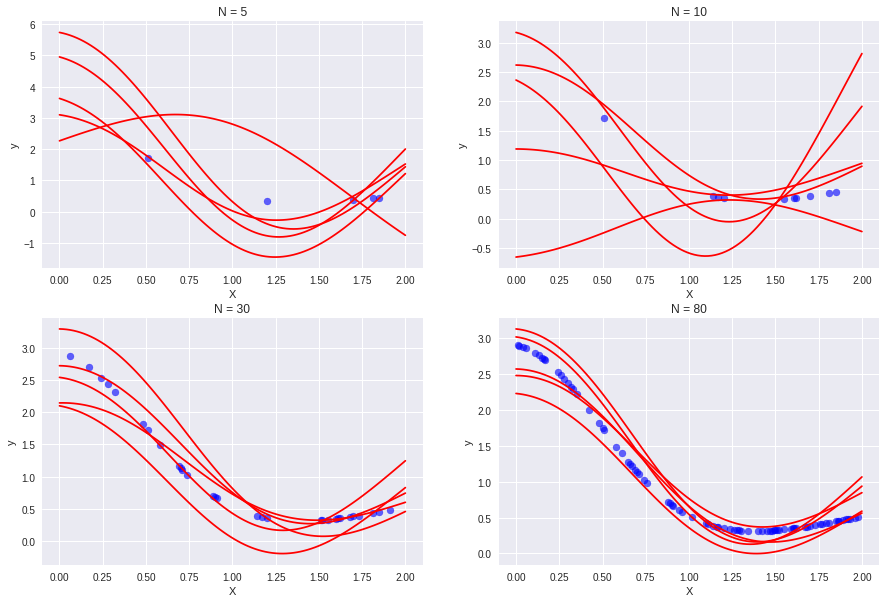

In [5]:
data_size = [5, 10, 30, 80]
x = np.linspace(0, 2, 100)
fig, ax = plt.subplots(2, 2, figsize=(15,10))
position = [(0, 0), (0, 1), (1, 0), (1, 1)]

for N, p in zip(data_size, position):
    model = SequentialBayesian()
    model.fit(X, y, N)
    mean, var = model.posterior_dist()
    prior = sampling(mean, var) # (5, 3)
    seq_x = model.basis_func.transform(x)

    ax[p].scatter(X[:N], y[:N], c='b', edgecolors='b', alpha=0.6)

    for w in prior:
        seq_y = [np.dot(point.T, w) for point in seq_x]
        ax[p].plot(x, seq_y, zorder = 1, color = 'red')
        ax[p].set_xlabel("X")
        ax[p].set_ylabel("y")
        ax[p].set_title(f"N = {N}")
plt.show()

## 1.2 Predictive Distribution

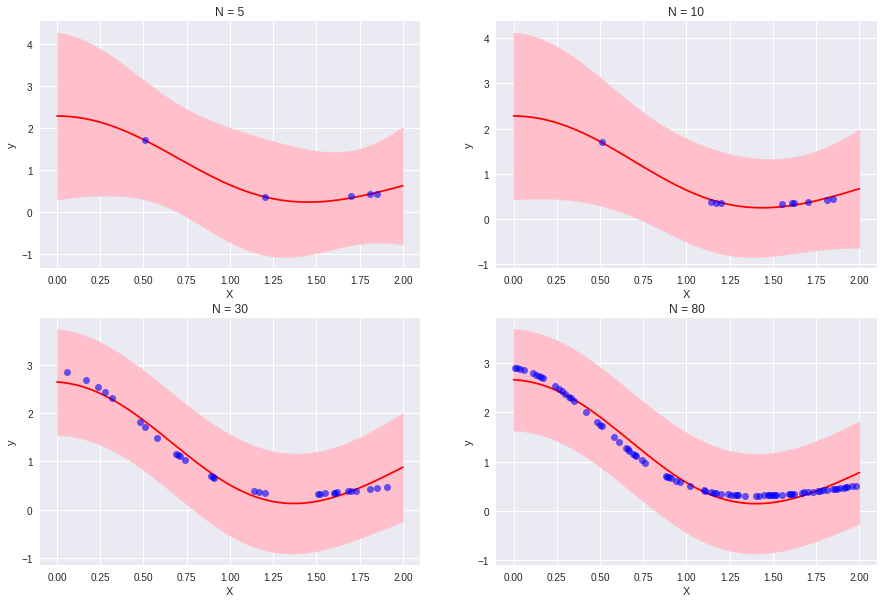

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))
position = [(0, 0), (0, 1), (1, 0), (1, 1)]

for N, p in zip(data_size, position):
    model = SequentialBayesian()
    model.fit(X, y, N)
    mean, var = model.posterior_dist()
    seq_x = model.basis_func.transform(x)
    mean, std = model.proedictive_dist(seq_x, mean.reshape(1, 3), var) # 1x100, 100x100
    mean, std = mean.flatten(), np.diagonal(std) #  (100, ), (100, )
    ax[p].plot(X[:N], y[:N], 'o', c='b', alpha=0.6)
    ax[p].plot(x, mean, zorder = 1, color = 'red')
    ax[p].fill_between(x, mean+std, mean-std, color='pink')
    ax[p].set_xlabel("X")
    ax[p].set_ylabel("y")
    ax[p].set_title(f"N = {N}")
plt.show()

## 1.3 Prior Distributions

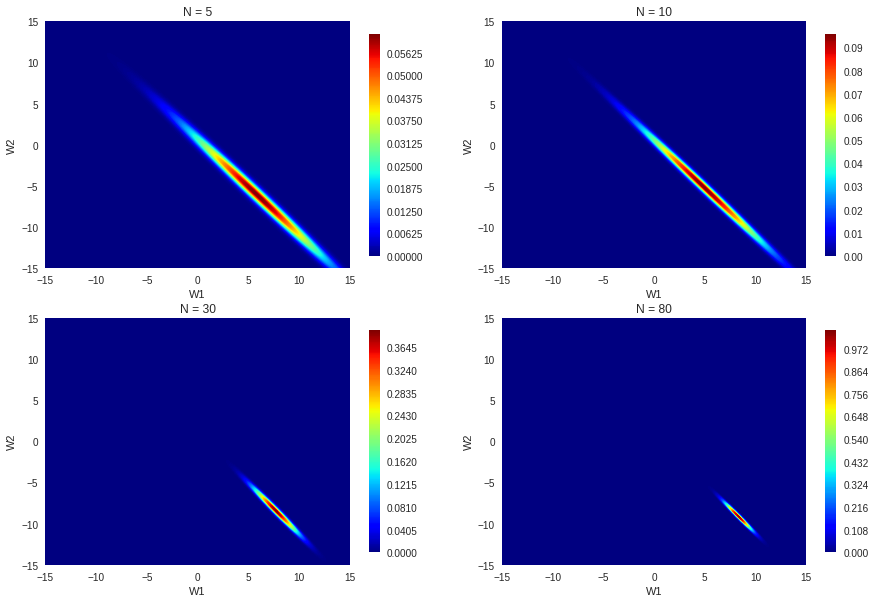

In [7]:
x = np.linspace(-15, 15, 300)
xx = np.dstack(np.meshgrid(x, x))

fig, axs = plt.subplots(2, 2, figsize=(15,10))
for N, ax in zip(data_size, axs.ravel()):
    model = SequentialBayesian(M=2) # 因為要畫圖，所以將M改成2
    model.fit(X, y, N)
    mean, var = model.posterior_dist()
    z = np.array([multivariate_normal.pdf(x, mean, var) for x in xx])
    cs = ax.contourf(x, x, z, len(x), cmap='jet') # colormap defalt = 'viridis'
    fig.colorbar(cs, ax=ax, shrink=0.9)
    ax.set_xlabel("W1")
    ax.set_ylabel("W2")
    ax.set_title(f"N = {N}")
plt.show()


## 1.4 Make some discussion

從 N =5 的圖片可以看出樣本只有五個時抽出的樣本變異性很大，

但是隨著樣本增加，prior distribution 能夠變動的範圍越來越小，這意味著我們對於**Prior distribution**越來越確定，

因為**樣本增加相當於資訊越來越豐沛** !

使得 **Posterior distribution** 也越來越確定，最後 **Posterior distribution** 的**平均值將收斂到當初產生資料的規律上**，

透過這個實驗也可以驗證課本所說的 **「 Sequential Bayesian Learning 有讓樣本自己說話的特性 」**。